In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import eli5
from eli5.sklearn import PermutationImportance

### Getting Relevant Data

In [2]:
query = """
SELECT table_id, row_count FROM `fccdsicapstone-218522.broadband.__TABLES__`
"""
tables = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

mask = (tables.table_id.str.contains('acs') &
        ~tables.table_id.str.contains('group') &
        ~tables.table_id.str.contains('level') &
        tables.row_count.between(190000, 220000))
tables[mask].sort_values('row_count', ascending=False)

,table_id,row_count
53,acs_with_geo_2014,216330
54,fcc_acs_with_geo_2014,216330
55,fcc_acs_with_geo_and_props_2014_table,216330
56,tiger_acs_2016_raw,216330
42,acs_with_geo_2015,216321
44,fcc_acs_with_geo_2015,216321
45,fcc_acs_with_geo_2016,216321
46,fcc_acs_with_geo_and_props_2015_table,216321
47,fcc_acs_with_geo_and_props_2016_table,216321
43,acs_with_geo_2016,216321


In [3]:
query_new = """
WITH block_level AS (
  SELECT 
    SUBSTR(block.block_code, 0, 12) AS block_group
    , CASE WHEN fcc.block_code IS NULL THEN 0 ELSE 1 END AS int_avail
    , CASE WHEN fund.census_block IS NULL THEN 0
           WHEN fund.max_down = 4 AND fund.max_up = 1 THEN 2
           ELSE 1 END AS fund_provided
    , CASE WHEN fcc.block_code IS NOT NULL AND fund.census_block IS NULL THEN 0 ELSE 1 END AS avail_not_funded
    
  FROM broadband.census_block block
  LEFT JOIN (SELECT DISTINCT block_code, holding_company_name FROM broadband.fcc WHERE file_date = 201706) fcc
    ON block.block_code = fcc.block_code
  LEFT JOIN broadband.fcc_demography
    ON block.block_code = fcc_demography.block_code
  LEFT JOIN broadband.fund
    ON block.block_code = fund.census_block
  WHERE fcc_demography.population_2016 > 0 AND fcc_demography.housing_unit_2016 > 0 
),


block_group_level AS ( 
  SELECT 
    block_group
    , AVG(int_avail) AS int_avail_per
    , AVG(fund_provided) AS fund_provided_per
    
  FROM (SELECT * FROM block_level WHERE avail_not_funded = 1 AND fund_provided < 2)
  GROUP BY block_group
)

SELECT DISTINCT
  block_group_level.block_group
  , block_group_level.int_avail_per
  , block_group_level.fund_provided_per
  , SAFE_DIVIDE(data.road_length, data.land_area) AS road_density
  , data.elev_mean
  , data.elev_range
  , data.winter_temp AS winter_temperature
  , SAFE_DIVIDE(data.population, data.land_area) AS population_density
  , data.male_rate
  , data.median_income
  , data.median_age
  , data.white_rate
  , data.avg_years_of_edu
  , data.unemployment_rate
  , SAFE_DIVIDE(data.housing_units, data.land_area) AS housing_density
  , data.house_owner_rate
  , data.newly_moved_household_rate
  , data.newly_built_housing_rate
  , law.laws_against
  --, IFNULL(law.type, 'no_law') AS law_type
FROM block_group_level
LEFT JOIN broadband.tiger_acs_2016 AS data
  ON block_group_level.block_group = data.block_group
LEFT JOIN broadband.laws_against_municipal_broadband law
  ON SUBSTR(block_group_level.block_group, 0, 2) = law.state_code
"""
all_data_new = pd.read_gbq(query_new, project_id='fccdsicapstone-218522', dialect='standard')

#### Only No Internet Available Blocks and Funded Blocks are included in this data

In [4]:
all_data_new.shape

(72849, 19)

### Data Cleaning for New Data

In [5]:
# np.unique(all_data_new['verizon_provided_per'])

In [6]:
all_data_new.count() / all_data_new.shape[0] * 100
data_new = all_data_new.dropna()
print(data_new.shape)

# mask = ((data_new.elev_range < data_new.elev_range.quantile(0.99)) &
#         (data_new.road_density < data_new.road_density.quantile(0.98)) &
#         (data_new.population_density < data_new.population_density.quantile(0.98)))

# data_new = data_new[mask]

data_new = all_data_new.dropna()

print(data_new.shape)

#convert the column of true/false to 1/0
data_new['laws_against'] = data_new['laws_against'].astype(int)

#data_new['verizon_provided_per'] = (data_new['verizon_provided_per'] > 0.5).astype(int)

(71174, 19)
(71174, 19)


/Users/spare/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### Model for New

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

target_col = 'fund_provided_per'
X = data_new.drop(columns=['int_avail_per', 'block_group', target_col])
y = data_new[target_col]
y = (y > 0.5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/Users/spare/anaconda3/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [8]:
y.value_counts()

0    52276
1    18898
Name: fund_provided_per, dtype: int64

### Balanced Model

In [11]:
# Random Forest Model

rfmodel_balanced = RandomForestClassifier(class_weight='balanced')
params = {
    'n_estimators': [100],
    'min_samples_split': range(10, 30, 5),
    'max_depth': range(10, 18, 5),
}

grid_search_balanced = GridSearchCV(estimator=rfmodel_balanced, param_grid=params,
                                    scoring='f1', cv=2, n_jobs=-1, verbose=True)
grid_search_balanced.fit(X_train, y_train)

print('Train score', grid_search_balanced.score(X_train, y_train))
print('Test score', grid_search_balanced.score(X_test, y_test))
print('Best Parameters:', grid_search_balanced.best_params_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.1min finished


Train score 0.7436668322396801
Test score 0.6218773253959817
Best Parameters: {'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 100}


## Saving a model 

In [91]:
import joblib

joblib.dump(grid_search_balanced, 'tuned_fund_model.joblib')
# grid_search_balanced = joblib.load('tuned_fund_model.joblib')

['tuned_fund_model.joblib']

# Feature Importance
### original methodology - `grid_search_balanced.best_estimator_.feature_importances_`

In [59]:
print (grid_search_balanced.best_params_)

coefficients = pd.DataFrame(list(zip(X.columns, grid_search_balanced.best_estimator_.feature_importances_))
                            , columns=['feature', 'gini_coef'])
coefficients_sort = coefficients.sort_values('gini_coef', ascending=False).reset_index(drop=True)

{'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 100}


Text(0.5,1,'Feature Importance')

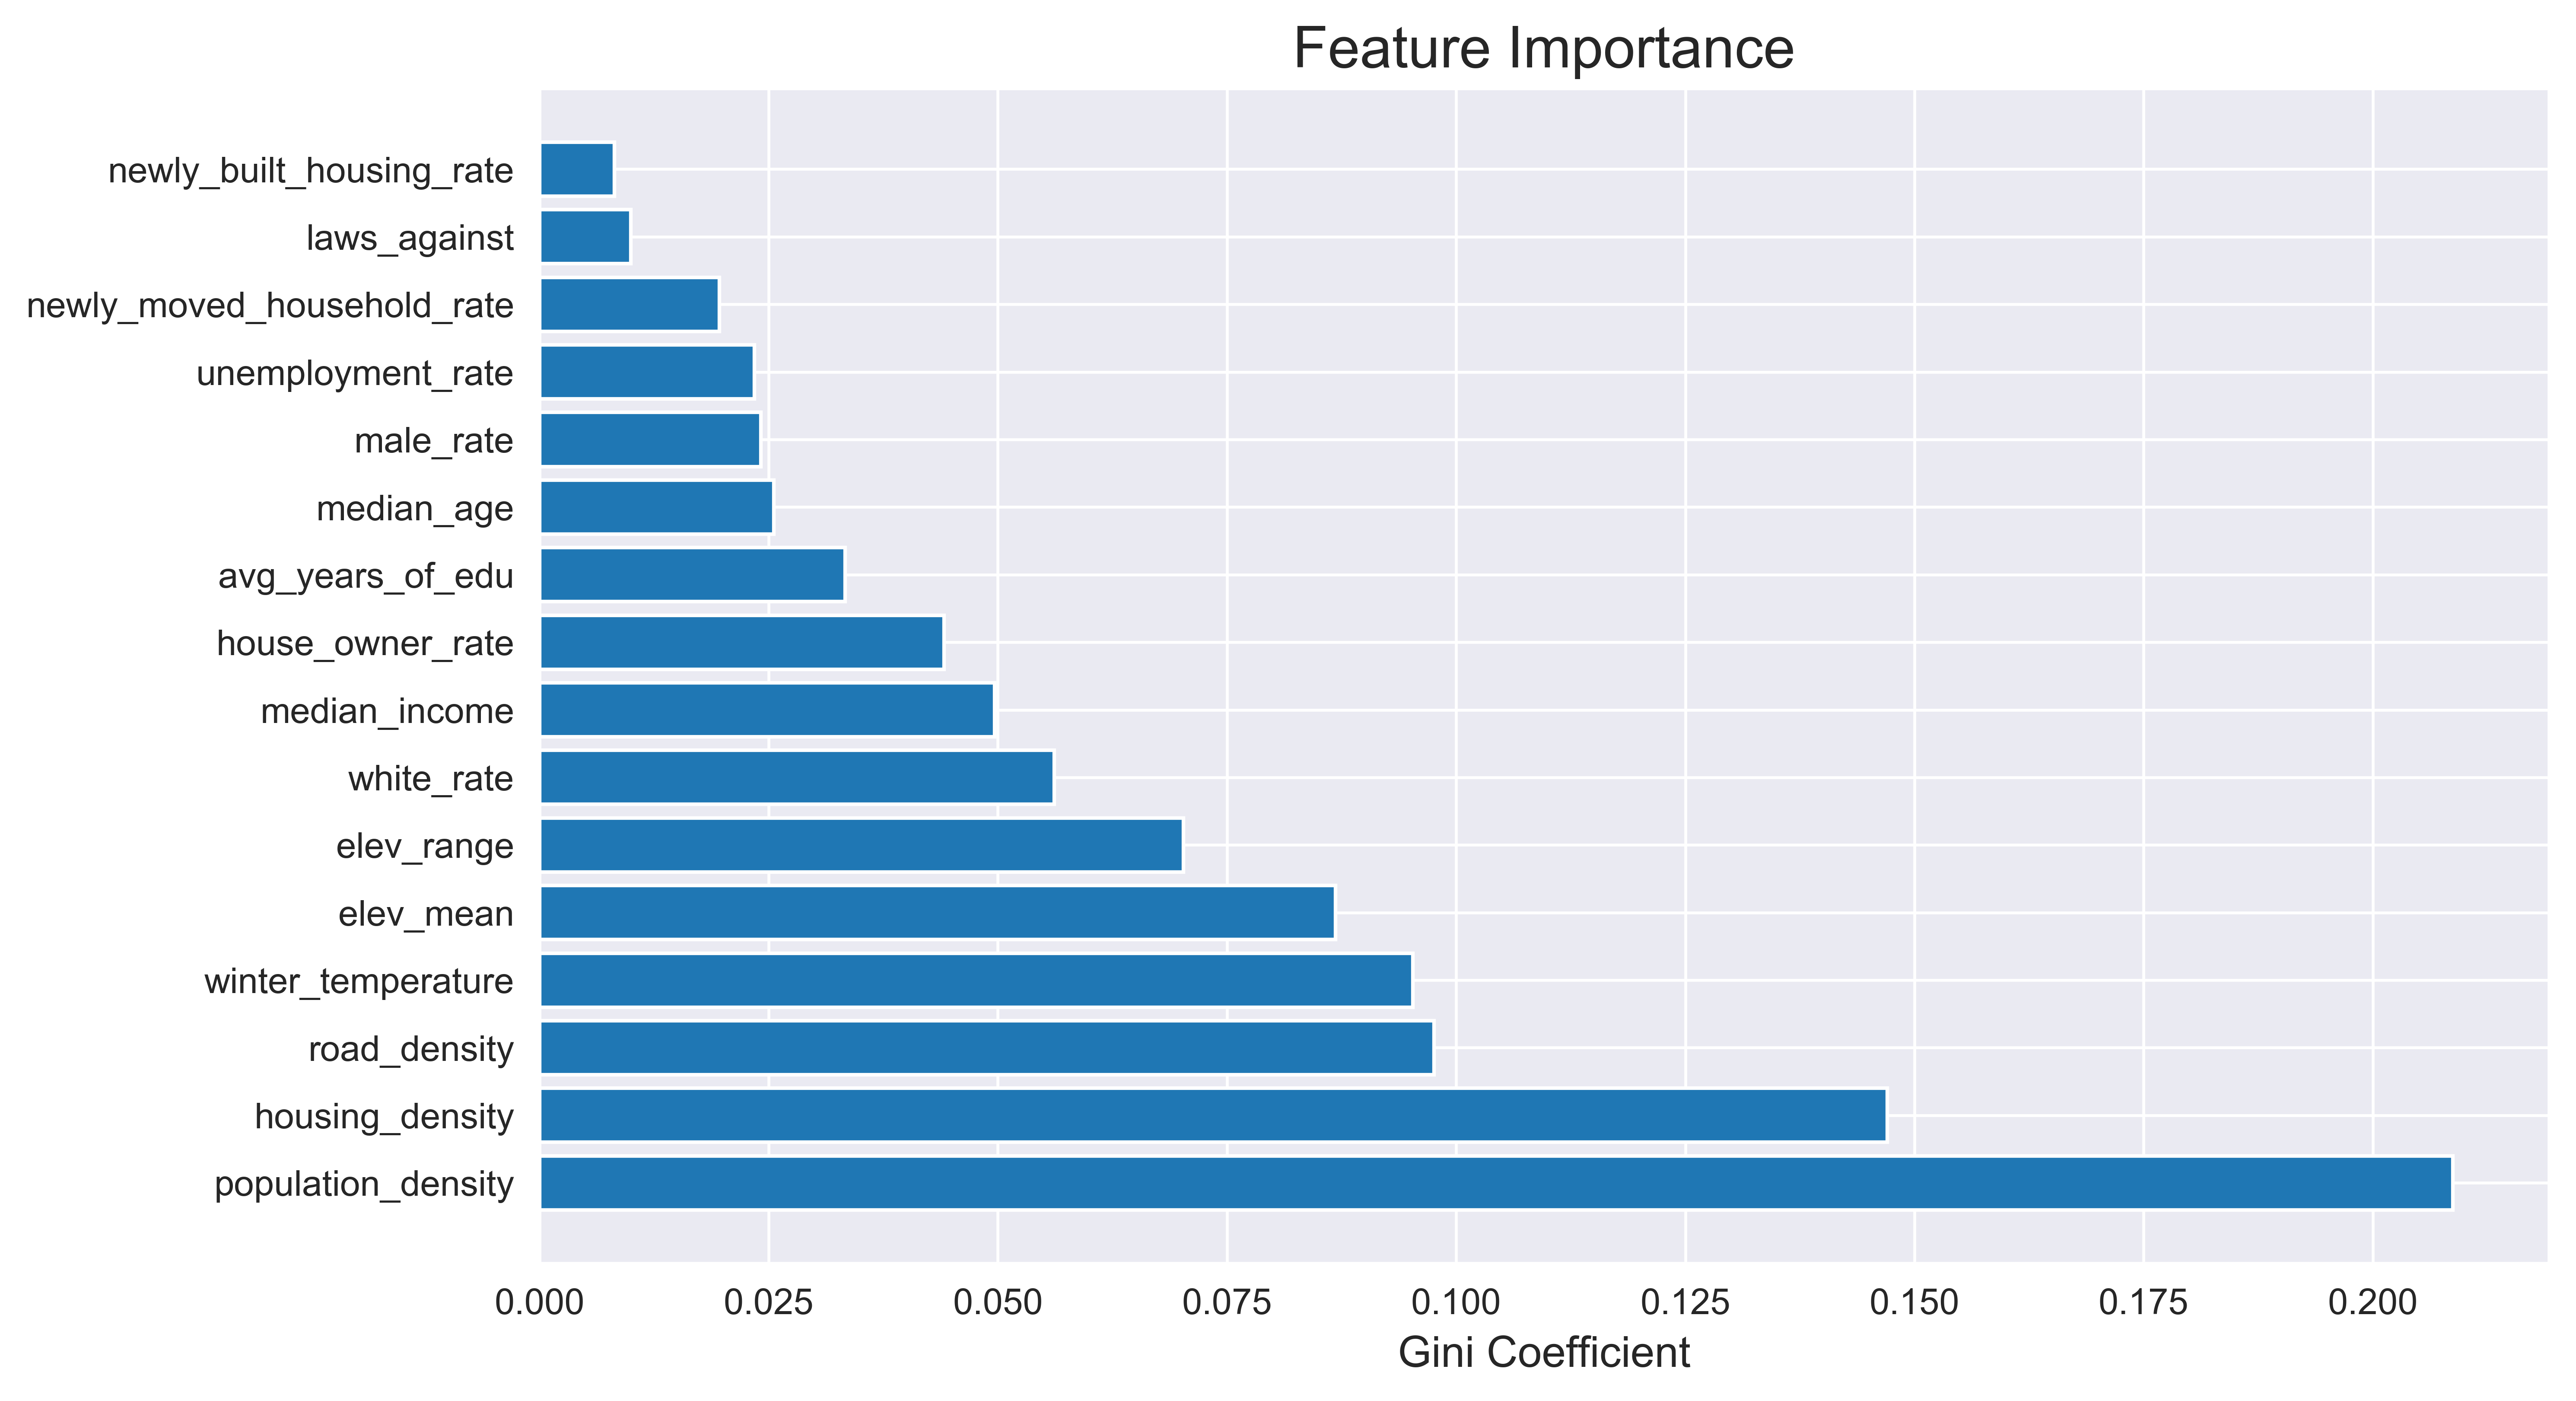

In [61]:
import seaborn as sns
# Set Seaborn Theme
sns.set_style('darkgrid')

fig = plt.figure(1, figsize=(10, 6), dpi=600)
plt.barh(coefficients_sort.index, coefficients_sort['gini_coef'].values)
plt.yticks(range(len(coefficients_sort)),coefficients_sort['feature'].values)
plt.xlabel('Gini Coefficient', fontsize=12)
plt.title('Feature Importance', fontsize=16)

### using permulation performance `perm.feature_importances_`

In [18]:
perm = PermutationImportance(grid_search_balanced.best_estimator_).fit(X_test, y_test)

In [62]:
print (grid_search_balanced.best_params_)

coefficients = pd.DataFrame(list(zip(X.columns, perm.feature_importances_))
                            , columns=['feature', 'feature_importance'])
coefficients_sort = coefficients.sort_values('feature_importance', ascending=False).reset_index(drop=True)

{'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 100}


Text(0.5,1,'Feature Importance')

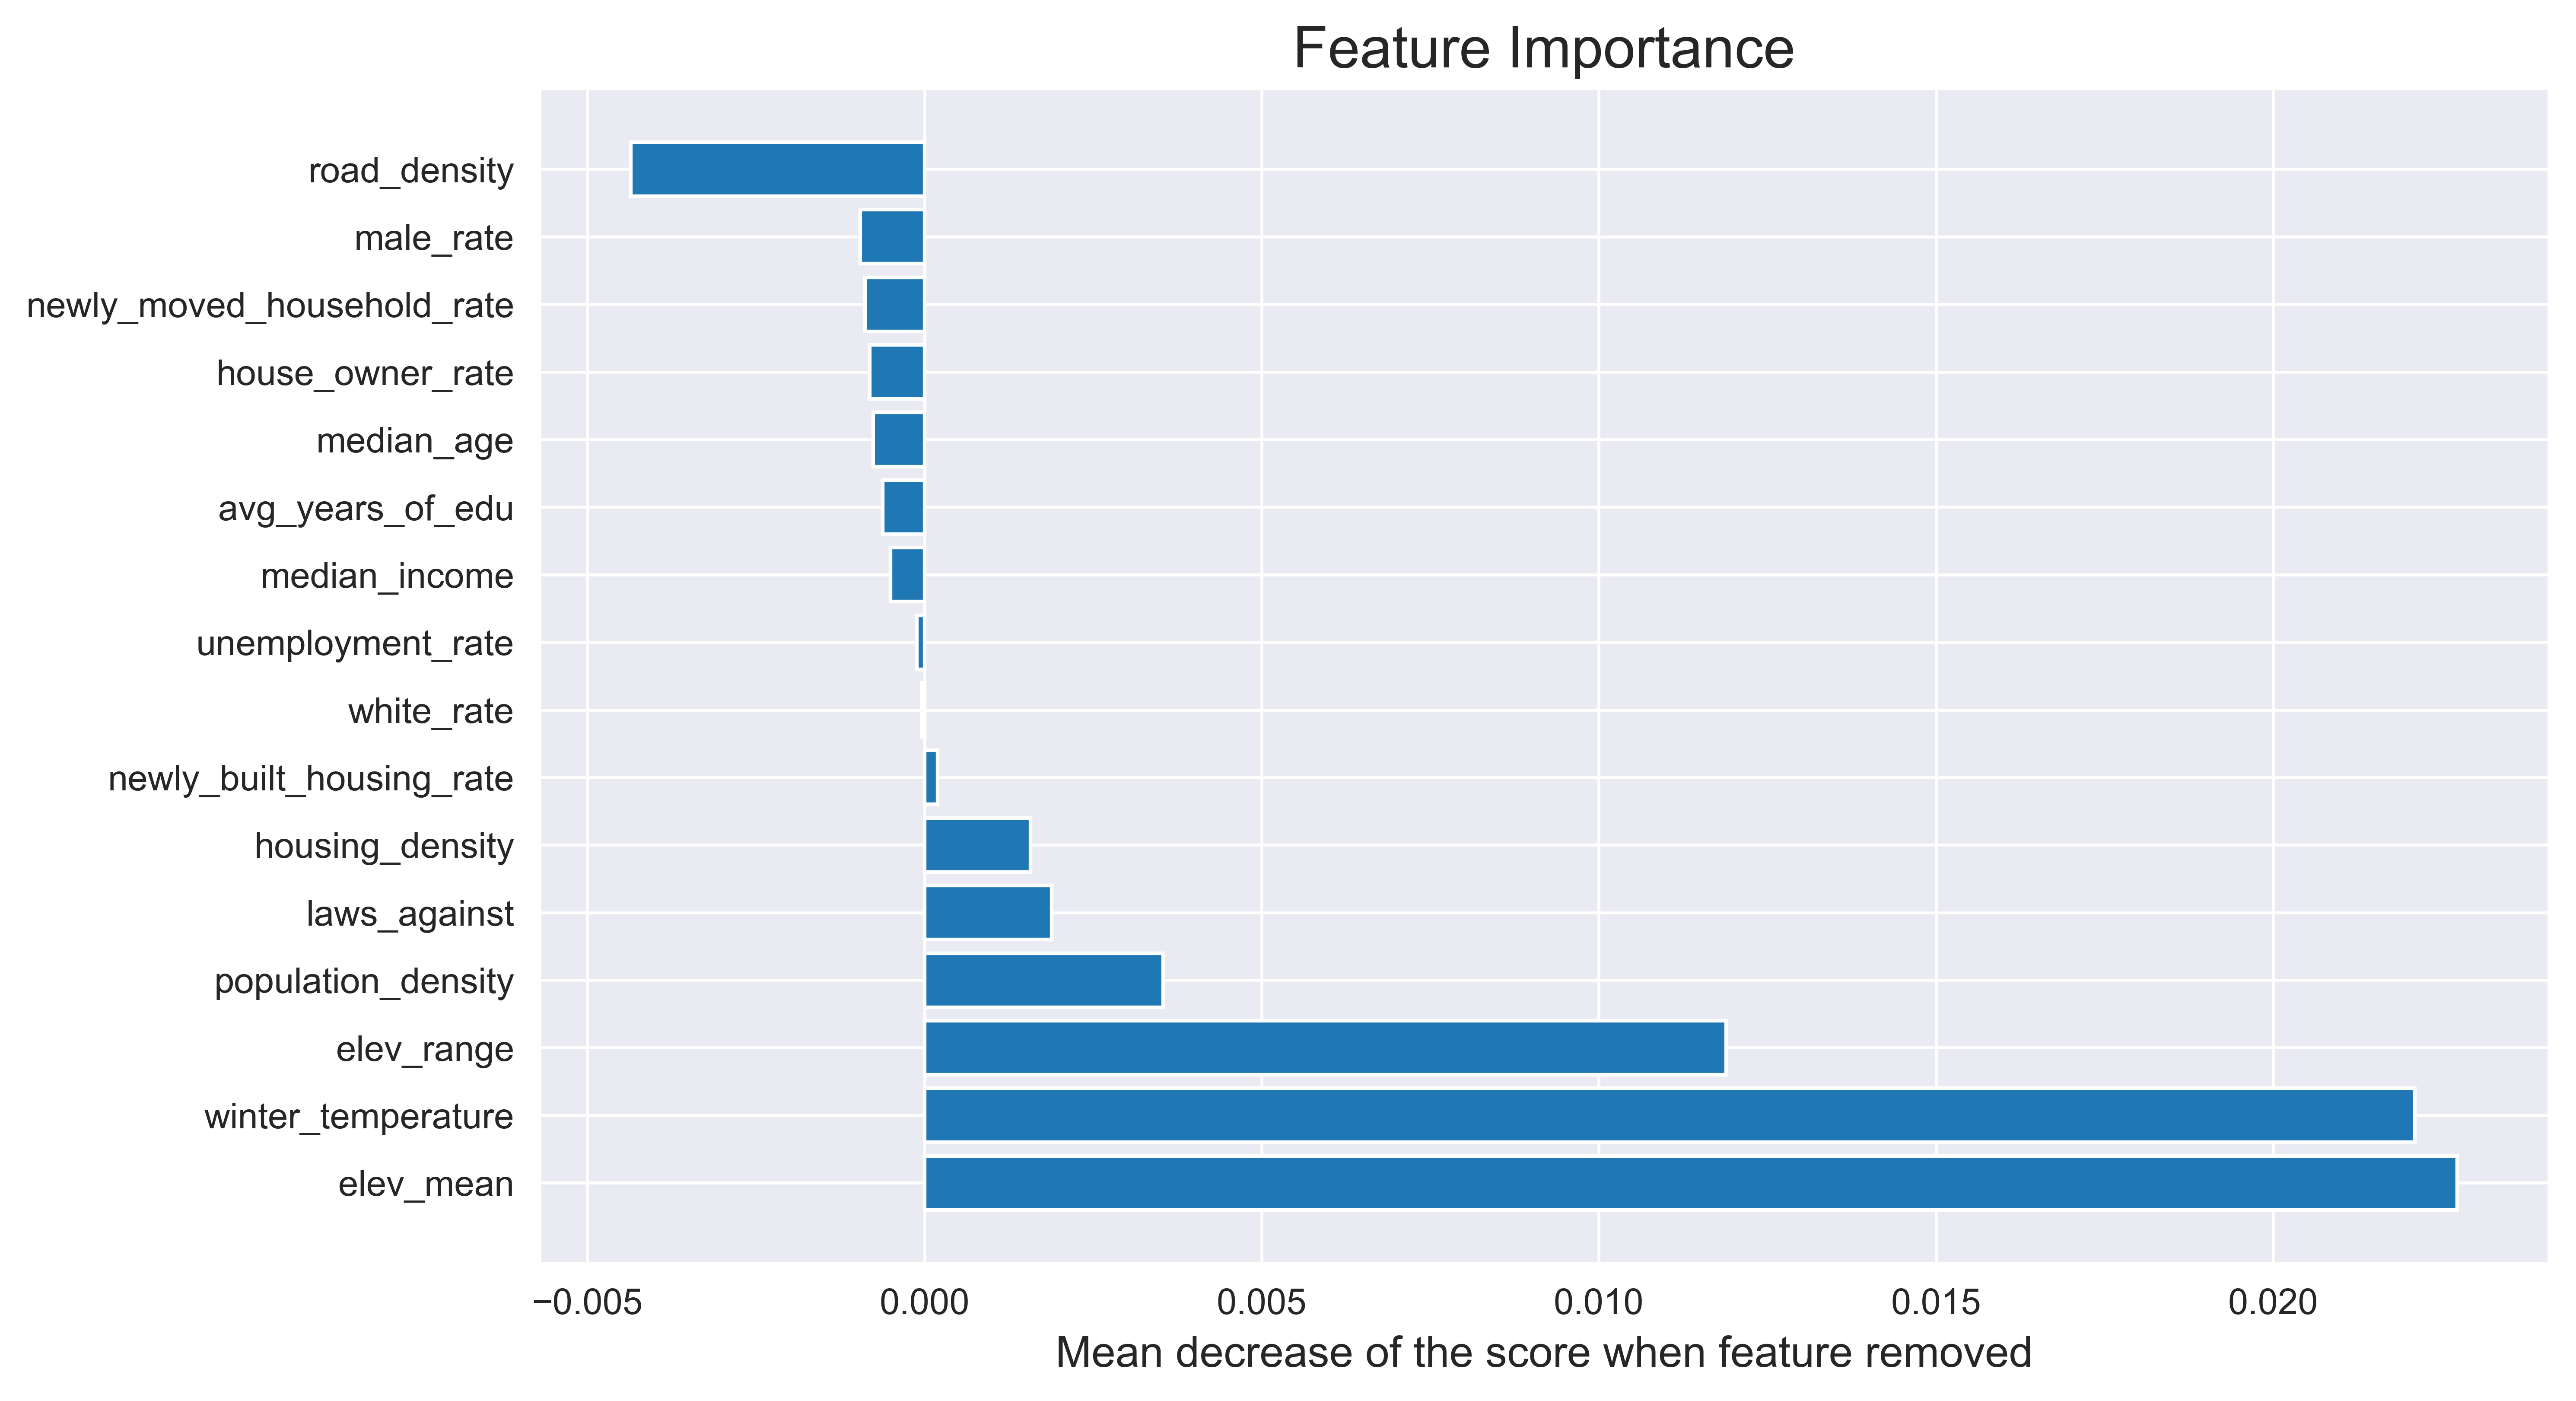

In [64]:
import seaborn as sns
# Set Seaborn Theme
sns.set_style('darkgrid')

fig = plt.figure(1, figsize=(10, 6), dpi=600)
plt.barh(coefficients_sort.index, coefficients_sort['feature_importance'].values)
plt.yticks(range(len(coefficients_sort)),coefficients_sort['feature'].values)
plt.xlabel('Mean decrease of the score when feature removed', fontsize=12)
plt.title('Feature Importance', fontsize=16)

# Confusion Matrix

In [95]:
from sklearn.metrics import confusion_matrix
CM_balanced = confusion_matrix(y_test, grid_search_balanced.predict(X_test))

In [96]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig = plt.figure(1, figsize=(10, 6), dpi=600)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()

Confusion matrix, without normalization
[[7660 2766]
 [ 846 2963]]


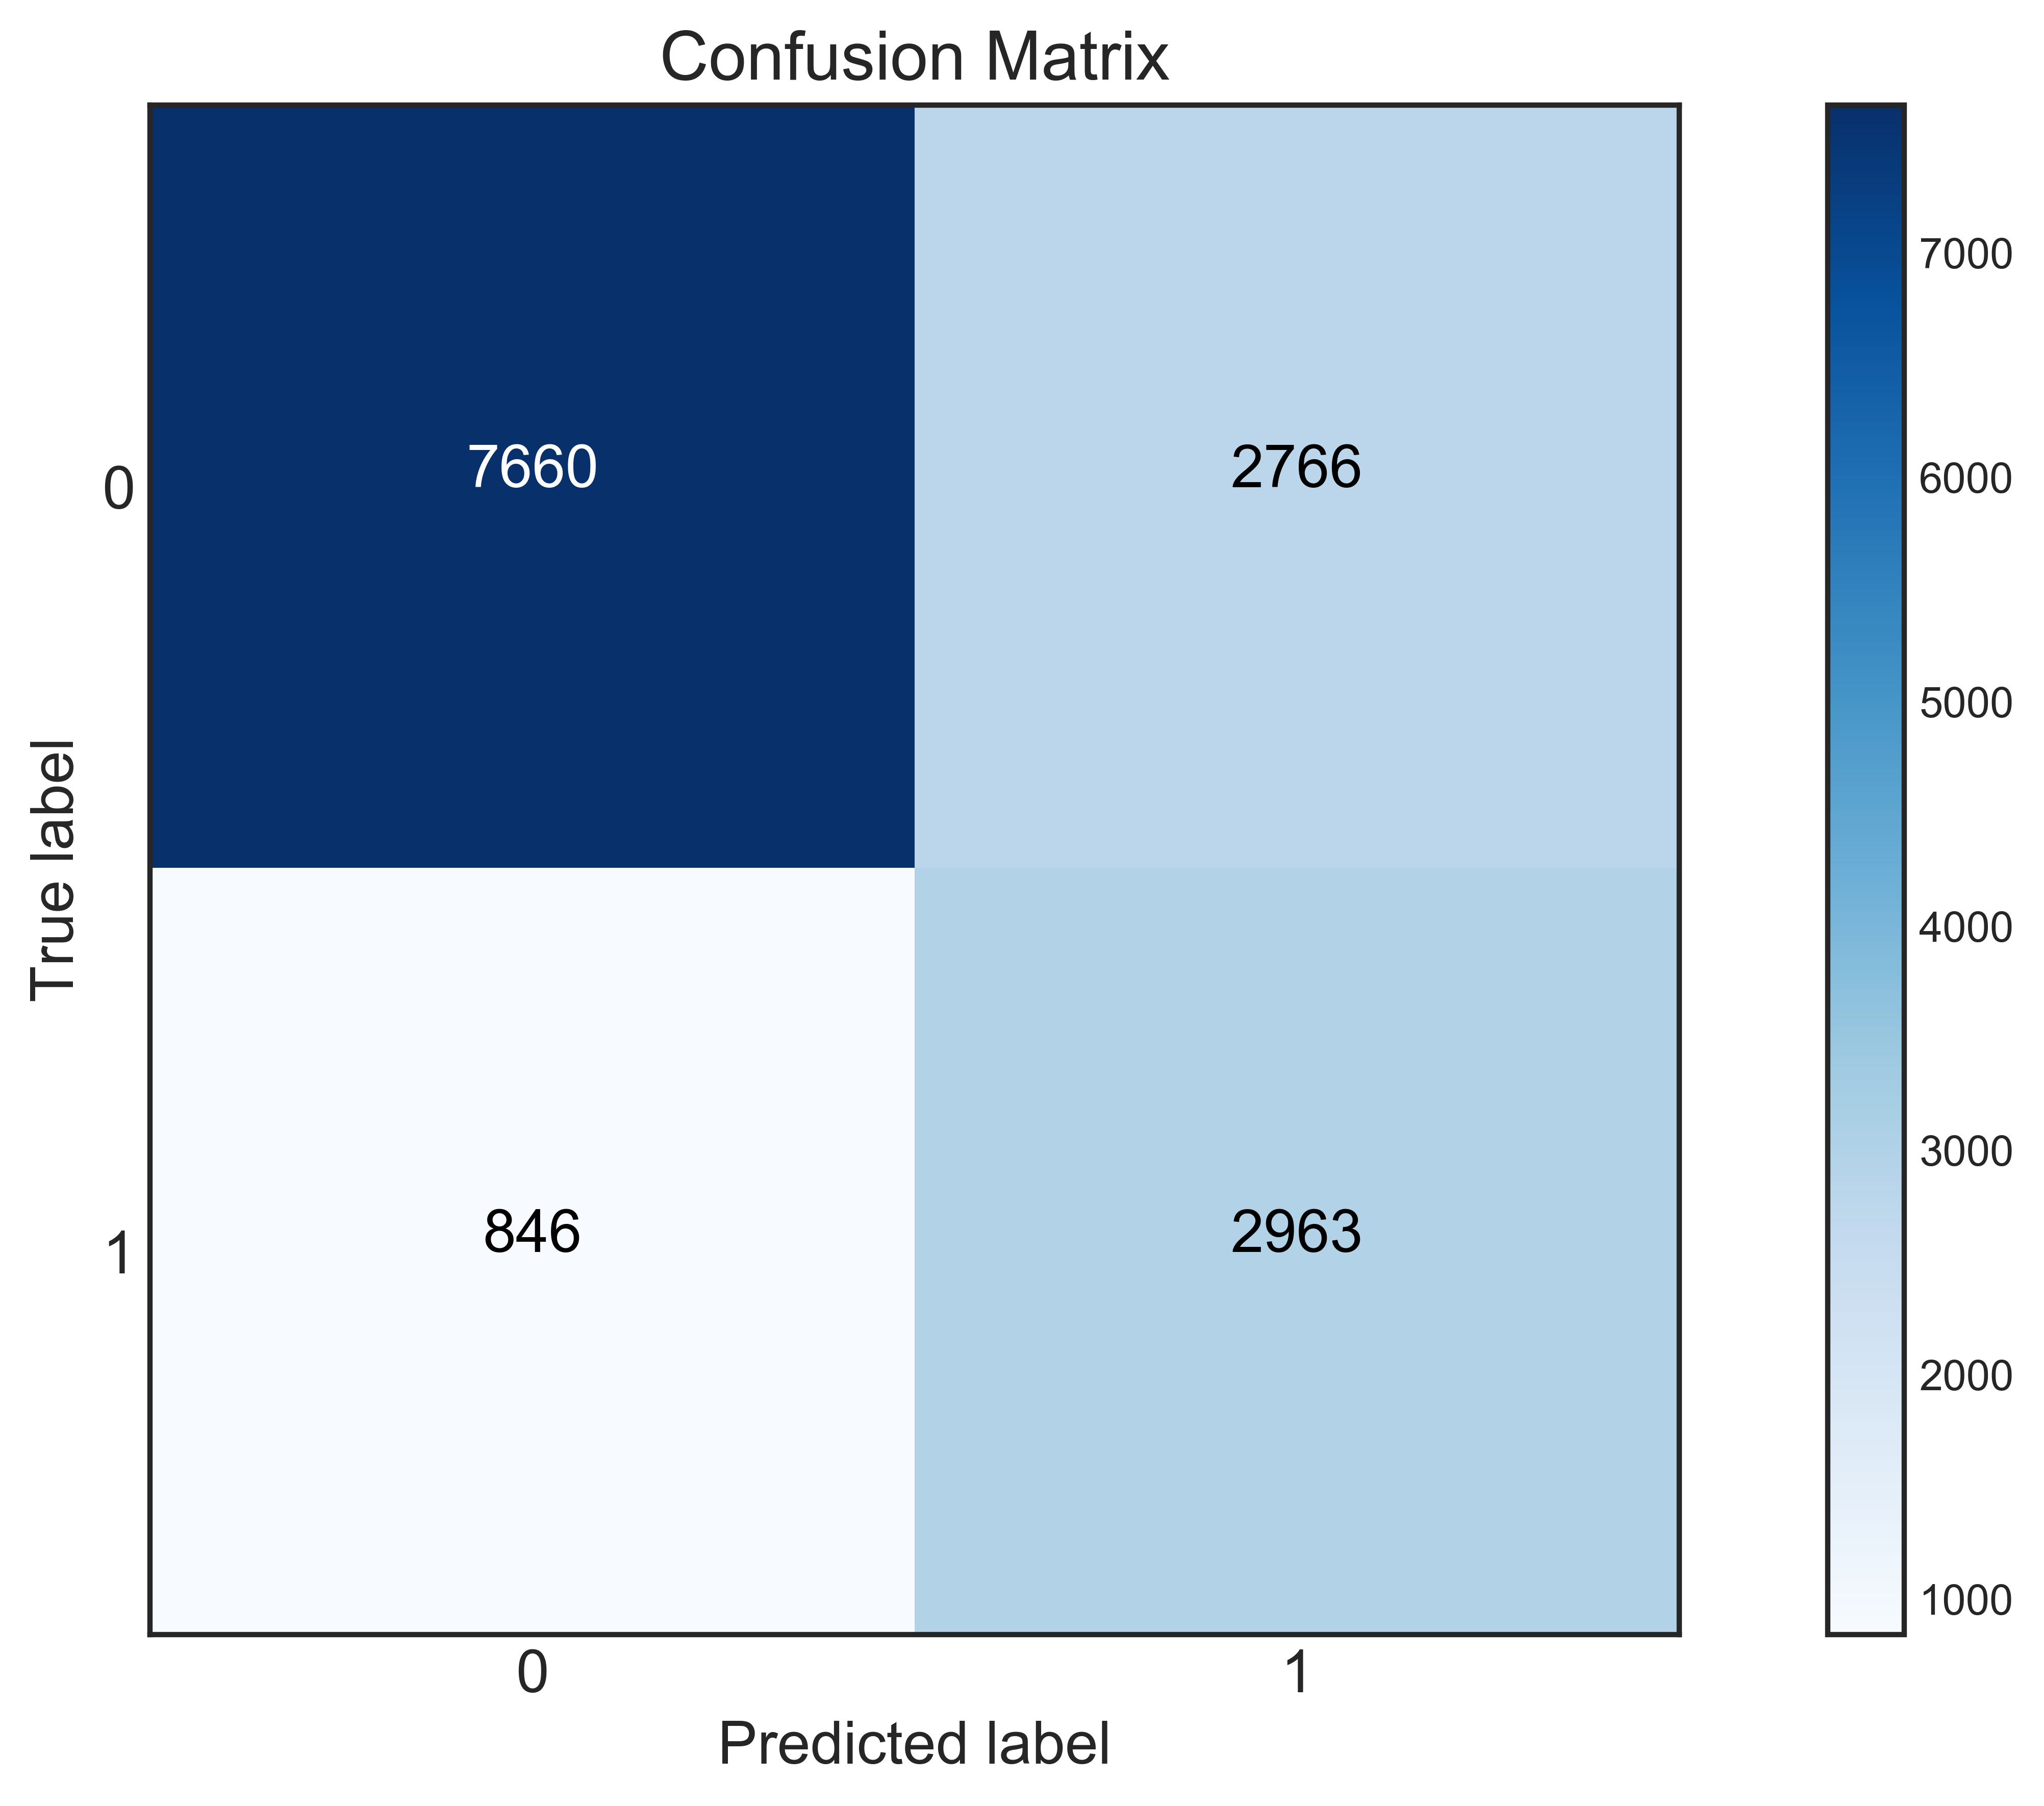

In [100]:
sns.set_style('white')
class_names = np.unique(y)
# Plot non-normalized confusion matrix
plot_confusion_matrix(CM_balanced, classes=class_names,
                      title='Confusion Matrix')
plt.show()

#Plot normalized confusion matrix
# plot_confusion_matrix(CM_balanced, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')
# plt.show()

### Predicting Block Groups that are likely to get funded in the future

In [98]:
no_enough_funded = data_new.iloc[np.where(y==0)].copy()

X_pred = no_enough_funded.drop(columns=['int_avail_per', 'block_group', target_col])
proba = grid_search_balanced.predict_proba(X_pred)
no_enough_funded['proba'] = proba[:, 1]

In [99]:
prediction = no_enough_funded.sort_values('proba', ascending=False)[['block_group', 'proba', 'fund_provided_per']]
prediction.to_csv('fund_prediction_result.csv', index=False)
prediction.head(10)

,block_group,proba,fund_provided_per
10014,271450112001,0.912720,0.250000
2433,271119617003,0.912567,0.181818
2260,270090201002,0.909773,0.423077
12209,270170705003,0.904822,0.446429
29066,551410111002,0.902118,0.000000
6488,271119601022,0.901060,0.370370
3169,271711009004,0.899063,0.434783
7304,550979612004,0.898341,0.371429
64854,270159607001,0.896017,0.000000
59732,551410107004,0.895830,0.000000


# Partial Dependance Plot

In [65]:
# from sklearn.ensemble.partial_dependence import partial_dependence
# partial_dependence(grid_search_balanced.best_estimator_, y_train)

In [68]:
from pdpbox import pdp, get_dataset, info_plots

In [94]:
!mkdir pdp

In [95]:
def make_pdp(feature):
    pdp_feature = pdp.pdp_isolate(
        model=grid_search_balanced.best_estimator_, dataset=X_train, model_features=X_train.columns, feature=feature)
    fig, axes = pdp.pdp_plot(pdp_feature, feature)
    fig.set_size_inches(6, 6)
    fig.savefig('pdp/'+feature+'.png')


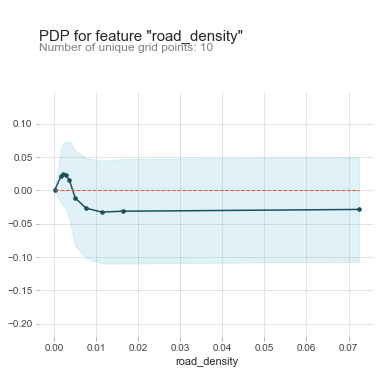

In [96]:
make_pdp('road_density')

road_density
elev_mean
elev_range
winter_temperature
population_density
male_rate
median_income
median_age
white_rate
avg_years_of_edu
unemployment_rate
housing_density
house_owner_rate
newly_moved_household_rate
newly_built_housing_rate
laws_against


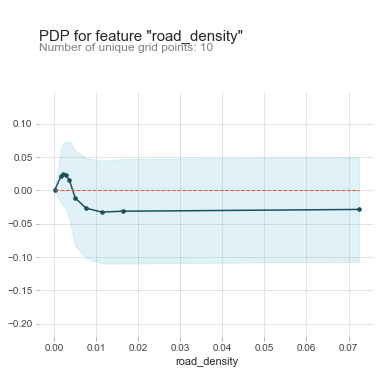

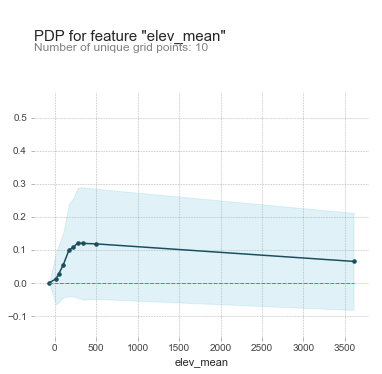

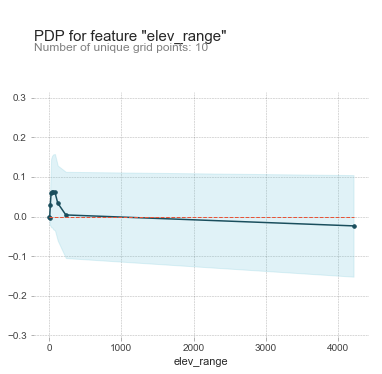

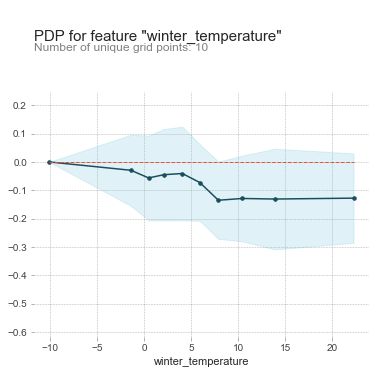

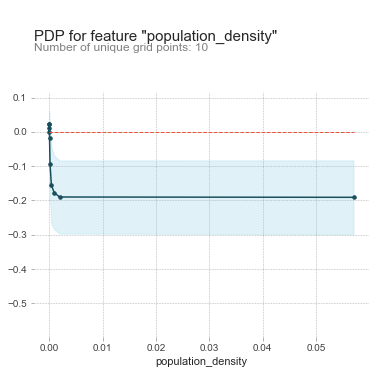

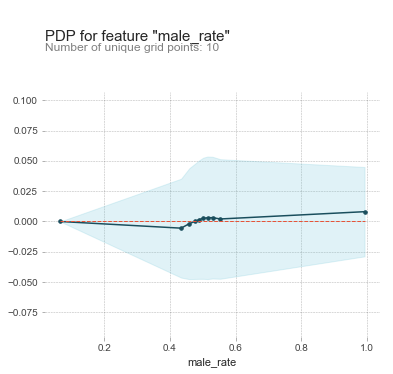

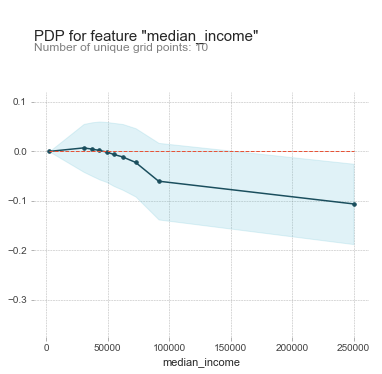

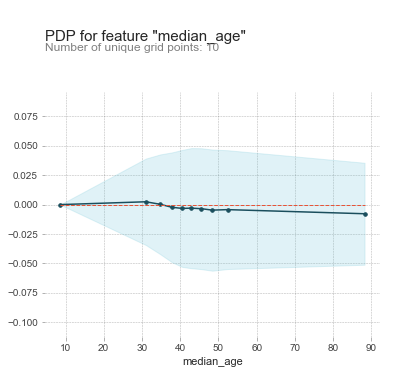

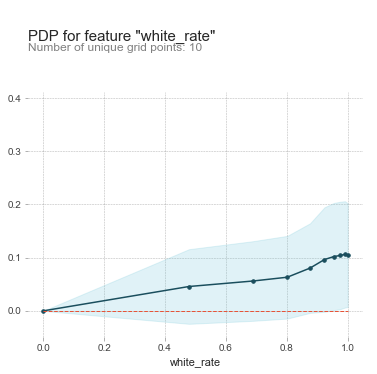

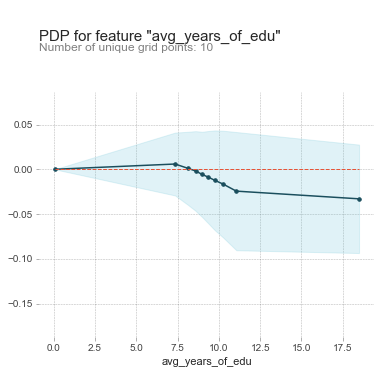

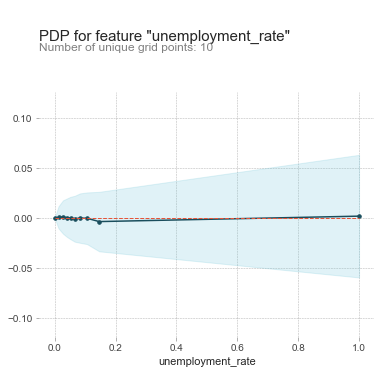

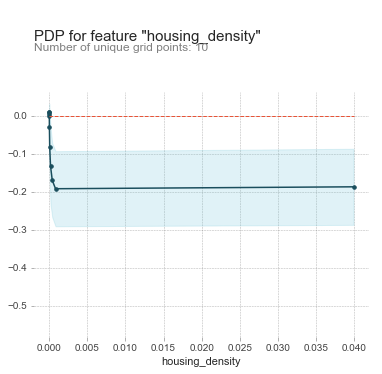

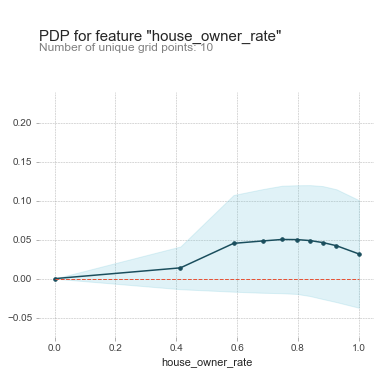

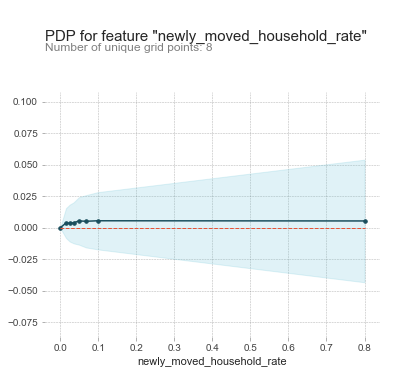

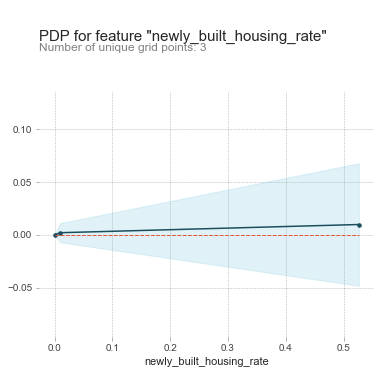

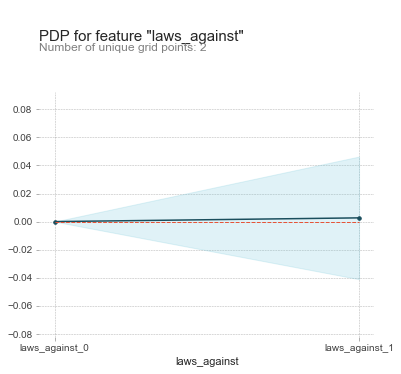

In [97]:
for i in X_train.columns.values:
    print(i)
    make_pdp(i)

# Prediction With Positive Importance Features


In [112]:
# Random Forest Model

rfmodel_balanced = RandomForestClassifier(class_weight='balanced')
params = {
    'n_estimators': [100],
    'min_samples_split': range(10, 30, 5),
    'max_depth': range(10, 18, 5),
}

X_train_positive_features = X_train[coefficients_sort[coefficients_sort.feature_importance>0].feature.values]
X_test_positive_features = X_test[coefficients_sort[coefficients_sort.feature_importance>0].feature.values]


grid_search_balanced = GridSearchCV(estimator=rfmodel_balanced, param_grid=params,
                                    scoring='f1', cv=2, n_jobs=-1, verbose=True)
grid_search_balanced.fit(X_train_positive_features, y_train)

print('Train score', grid_search_balanced.score(X_train_positive_features, y_train))
print('Test score', grid_search_balanced.score(X_test_positive_features, y_test))
print('Best Parameters:', grid_search_balanced.best_params_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   32.4s finished


Train score 0.7217809364548494
Test score 0.6302787162162162
Best Parameters: {'max_depth': 15, 'min_samples_split': 20, 'n_estimators': 100}


In [110]:
features = list(coefficients_sort[coefficients_sort.feature_importance>0].feature.values)